# Ekman_spiral
  
an elementary upper ocean Ekman layer
Solve a 1-D diffusion flow numerically.  This version has rotation, and thus makes an Ekman layer.  The IC is a state of rest.  The fluid is forced by an imposed stress at the top of the column (z=0) The lower boundary condition is free-slip to minimize the effect of finite depth. 

Original code by Jim Price, Oct 99
Modified version by Marcello Vichi, for UCT Oceanography

In [259]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [260]:
# user inputs
dz = 5.          #  [m] grid interval
L = 200.         #  [m] water column depth  
ndays = 20.      #  [day] days to integrate
A = 5.e-2       #  [m2/s] the eddy diffusivity
lat = -45.       #  [deg] specify the latitude here

In [261]:
# plot profiles every nplot steps
nplot = 25

#constants
omega = 7.29e-5  # [s-1] 2pi/86400
rho0 = 1025.    #  [kg/m3] nominal constant density of water
w = 0.4          # the Courant number dt*A/dz^2
                  # must be less than 0.5 for numerical stability

In [262]:
# grid specifications
z = np.arange(0, -L - dz, -dz)    # the grid definition
nz = len(z)
dt = w*dz**2/A   # the time step is derived from the Courant number
nstep = round(ndays*86400/dt) # number of steps per day
time = np.zeros((nstep, 1))


In [263]:
# Calculate sheerstress based on wind speed and direction
def shearstress(Ws,Wd):
    pAir = 1.3 # Air density (kg/m^3)
    Cd = 0.013 # drag coefficient

    Wx = Ws*np.cos(np.radians(270)-np.radians(Wd)) # Zonal wind speed component (E(+)/W(-))
    Wy = Ws*np.sin(np.radians(270)-np.radians(Wd)) # Medidional wind speed component (N(+)/S(-))
    
    Tx = pAir*Cd*Wx**2
    Ty = pAir*Cd*Wy**2
    
    return np.array([Tx,Ty])

# Theoretical Ekman transport (Ektrans) and Ekman depth (Ekdepth)
def calculate_ekman_transport(Tauwx, Tauwy, rho0, f):
    return np.sqrt(Tauwx**2+Tauwy**2)/rho0/f

def calculate_ekman_depth(A, f):
    return np.sqrt(2*A/abs(f))

# time series at different depths
def plot_depth_timeseries(time, SECPERDAY, usurf, umid, udeep, vsurf, vmid, vdeep):
    dtime=time/SECPERDAY
    f1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
    ax1.plot(dtime, usurf, label = "Surface")
    ax1.plot(dtime, umid, label="Midwater")
    ax1.plot(dtime, udeep, label="Deepwater")
    ax1.set_ylabel('East [m/s]')
    ax1.grid(True)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax1.set_title('East and North currents')
    
    
    ax2.plot(dtime, vsurf, label='Surface')
    ax2.plot(dtime, vmid, label='Midwater')
    ax2.plot(dtime, vdeep, label='Deepwater')
    ax2.set_ylabel('North [m/s]')
    ax2.set_xlabel('time [day]')
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.grid(True)

    ax3.plot(dtime, np.sqrt(usurf**2 + vsurf**2), label='Surface')
    ax3.plot(dtime, np.sqrt(umid**2 + vmid**2), label='Midwater')
    ax3.plot(dtime, np.sqrt(udeep**2 + vdeep**2), label='Deepwater')
    ax3.set_ylabel('North [m/s]')
    ax3.set_xlabel('time [day]')
    ax3.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax3.grid(True)

# transport
def plot_transport(transu, transv, Ektrans):
    f1, ax = plt.subplots(figsize=(12, 8))
    ax.plot(transu, transv, linestyle='dotted', label='instantaneous')
    
    Tx = np.mean(transu)
    Ty = np.mean(transv)
    ax.plot([0,Tx], [0, Ty], 'g-o', label='average')
    ax.plot([0,Ektrans], [0,0],'r-+', label='theoretical')
    ax.set_xlabel('U transport [m2/s]')
    ax.set_ylabel('V transport [m2/s]')
    # axis([-0.1 0.15 -0.25 0.])
    ax.axis('equal')
    ax.set_title('Transport with time, average and theoretical value')
    ax.grid(True)
    ax.legend()

# mean velocity profiles
def plot_mean_velocity_profiles(uavg, vavg, z, Ekdepth):
    f1, ax = plt.subplots(figsize=(12, 8))
    ax.plot(uavg, z,'r',linewidth=2, label='E')
    ax.plot(vavg, z,'b',linewidth=2, label='N')
    ax.set_xlabel('East and North currents [m/s]')
    ax.set_ylabel('Depth [m]')
    ax.set_title('Mean current profiles')
    
    h, = ax.plot([-0.1, 0.2], [-Ekdepth, -Ekdepth], linestyle='--', label='Ekman depth')
    ax.legend()

#hodograph
def plot_hodograph(uavg, vavg):
    f1, ax = plt.subplots(figsize=(12, 8))
    ax.quiver(0, 0, 0, 0.06, color='r', angles='xy', scale_units='xy', scale=1, width=0.01)
    ax.quiver(np.zeros(uavg.shape),np.zeros(uavg.shape),uavg,vavg,angles='xy', scale_units='xy', scale=1, width=0.01)
    ax.set_xlabel('East component [m/s]')
    ax.set_ylabel('North component, [m/s]')
    ax.set_title('Hodograph, dz = 2.5 m')
    ax.set_xlim(-0.03, 0.005)
    ax.set_ylim(-0.01, 0.06)
    ax.grid(True)


# spiral in 3D
def plot_3D_ekman_spiral(uavg, vavg):
    f1, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(12, 8))
    h1 = ax.quiver(np.zeros(uavg.shape), np.zeros(uavg.shape), z, uavg, vavg, np.zeros(uavg.shape), linewidth=1.3)
    x3 = [0, 0, 0]
    y3 = [0, 0, 0.1]
    z3 = [-L, 0, 0]
    
    h2, = ax.plot(x3, y3, z3, 'r-', linewidth=1.5)
    ax.set_xlabel('East component [m/s]')
    ax.set_ylabel('North component, [m/s]')
    ax.set_zlabel('Depth [m]')
    ax.grid(True)

In [264]:
def simulate_ekman_transport(nstep, time, dt, z, w, Tauwx, Tauwy, rho0, A, lat):
    SECPERDAY = 86400
    f = 2 * omega * np.sin(np.radians(lat))     # the Coriolis parameter
    # Variables and Initial conditions
    u = np.zeros(z.shape)         #  the dependent variable, velocity
    v = np.zeros(z.shape) 
    uavg = np.zeros(z.shape) 
    vavg = np.zeros(z.shape) 
    navg = 0
    
    #initialise 
    delsqu = np.zeros(z.shape)
    delsqv = np.zeros(z.shape)
    
    usurf = np.zeros((nstep, 1))
    vsurf = np.zeros((nstep, 1))
    umid = np.zeros((nstep, 1))
    vmid = np.zeros((nstep, 1))
    udeep = np.zeros((nstep, 1))
    vdeep = np.zeros((nstep, 1))
    
    transu = np.zeros((nstep, 1))
    transv = np.zeros((nstep, 1))

    uStore = np.zeros(z.shape + (int(nstep/25),)) 
    vStore = np.zeros(z.shape + (int(nstep/25),))
    
    # set figure attributes
    f1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    
    ax1.set_ylabel('depth [m]')
    ax1.set_xlabel('Zonal current [m/s]')
    ax1.set_title(r'Upper ocean Ekman layer, $\tau_y = 0.1 N m^{-2}$')
        
    
    ax2.set_ylabel('depth [m]')
    ax2.set_xlabel('Meridional current, [m/s]')
    
    
    #  begin time-stepping
    ht = [] # handle for the time string in the figure
    for n in range(nstep):
        
        # advance time
        time[n] = (n-1)*dt
    
    
        # evaluate the diffusion term
        delsqu = np.concatenate(([0], u[:-2] - 2*u[1:-1] + u[2:], [0]))
        delsqv = np.concatenate(([0], v[:-2] - 2*v[1:-1] + v[2:], [0]))
        
        # Euler forward solution with Coriolis
        u = u + w*delsqu + dt*f*v
        v = v + w*delsqv - dt*f*u
        
        # Apply the surface boundary condition
        u[0] = u[1] + dz * (Tauwx / (rho0 * A))
        v[0] = v[1] + dz * (Tauwy / (rho0 * A))
    
        # Apply the bottom boundary condition (Neumann, free-slip)
        u[-1] = u[-2]
        v[-1] = v[-2]
        
        # Diagnostics
        
        #  1) time-average (after the first day)
        if time[n]/SECPERDAY >= 1:
            uavg = uavg + u
            vavg = vavg + v
            navg = navg + 1
        
        
        # 2) time series of surface current
        usurf[n] = u[0]
        vsurf[n] = v[0]
        mid = int(np.round(2*nz/3) -2)
        umid[n] = u[mid]
        vmid[n] = v[mid]
        udeep[n] = u[nz-4]
        vdeep[n] = v[nz-4]
    
        # 3) time series of transport
        transu[n] = (sum(u) - u[0])*dz
        transv[n] = (sum(v) - v[0])*dz
    
        # plot profile every nplot time steps
        if (n % nplot) == nplot - 1:
            #figure(f1)
            ax1.plot(u, z)
            ax2.plot(v, z)
            stepNo = n/nplot
            uStore[:,int(stepNo)] = u
            vStore[:,int(stepNo)] = v
            #if ht == []:
            #    del ht
            #ht=plt.text(-0.03,-90,['time=',num2str(time(n)/SECPERDAY,3)])


            
    
    # compute mean profile
    #uavg = uavg/navg
    #vavg = vavg/navg
    
    if navg > 0:
        uavg /= navg
        vavg /= navg

    #  plot diagnostics
    #Ektrans = calculate_ekman_transport(Tauwx, Tauwy, rho0, f)
    Ekdepth = calculate_ekman_depth(A, f)
    
    #plot_depth_timeseries(time, SECPERDAY, usurf, umid, udeep, vsurf, vmid, vdeep)
    #plot_transport(transu, transv, Ektrans)
    #plot_mean_velocity_profiles(uavg, vavg, z, Ekdepth)
    #plot_hodograph(uavg, vavg)
    #plot_3D_ekman_spiral(uavg, vavg)

    return uStore,vStore

To do for presentation: 
- start in "stationary position" and see the development, be able to change the wind speed and see how it changes the ekman transport / currents/ ekman depth. Show it via vertical section. - need timeseries of outputs so we can make an animation from that
- talk about limits to ekman effects with depth- what is max ekman depth
- do different latitudes ie different coriolis effect


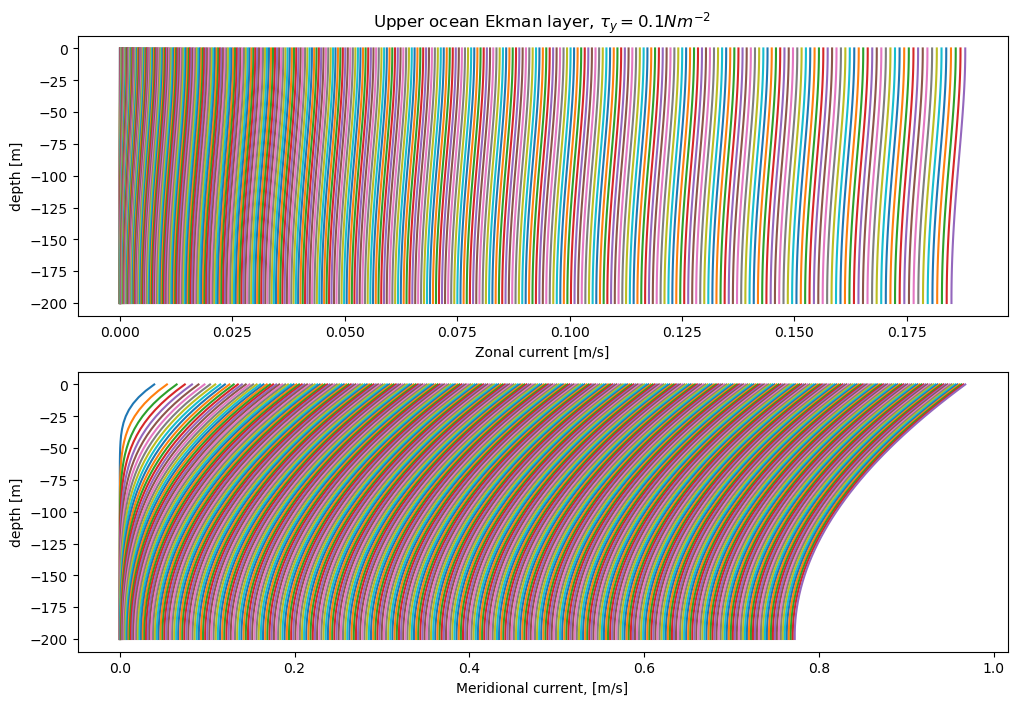

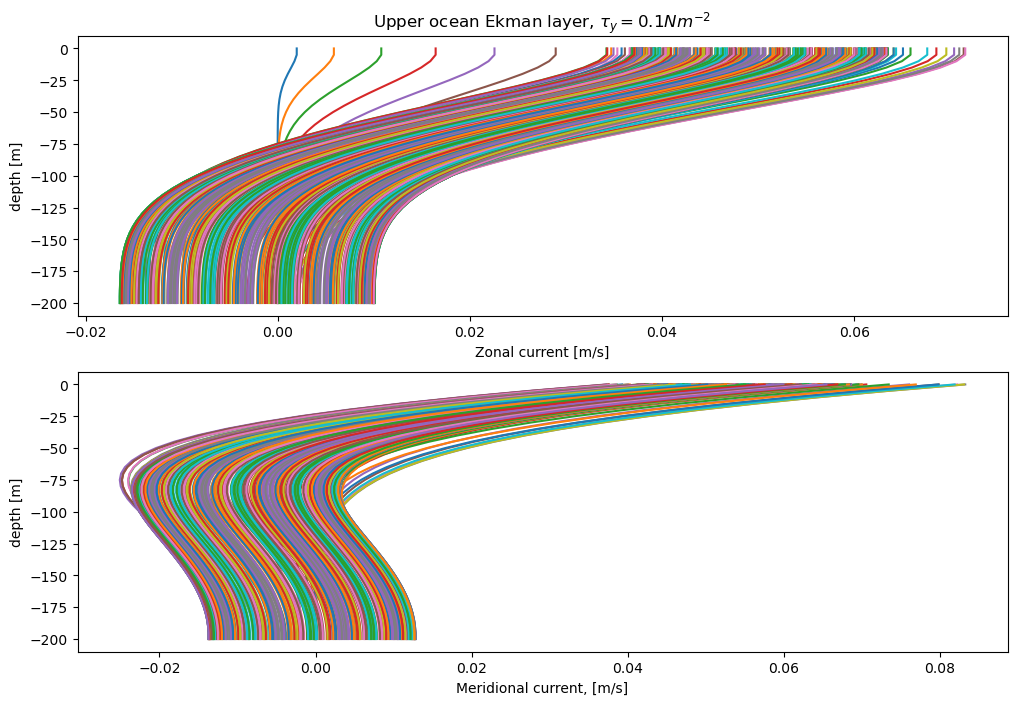

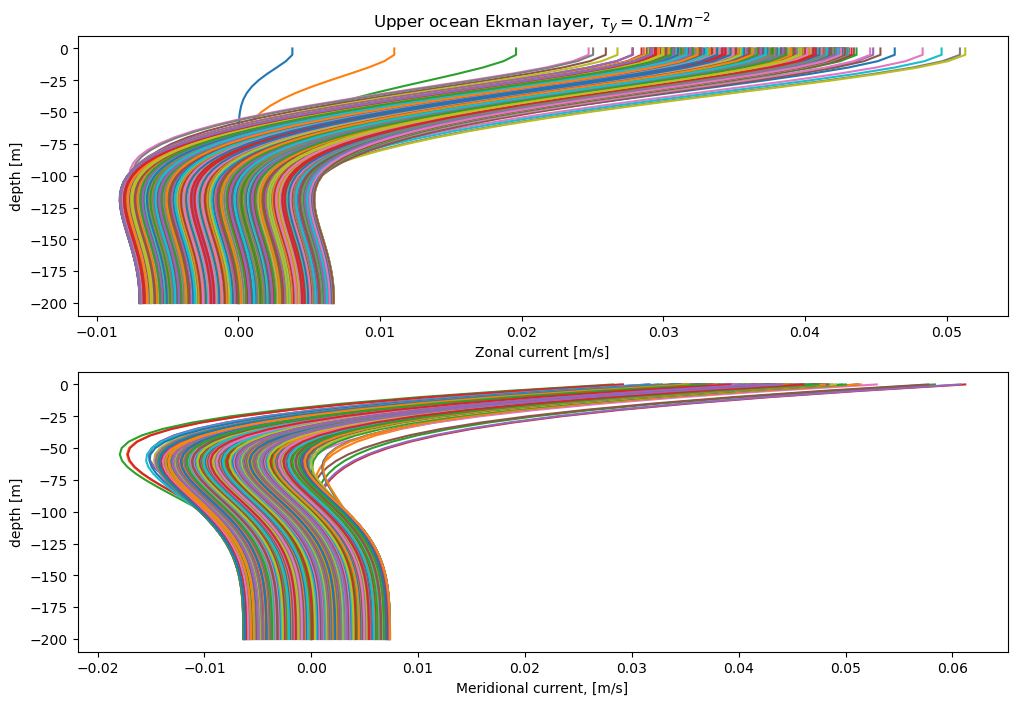

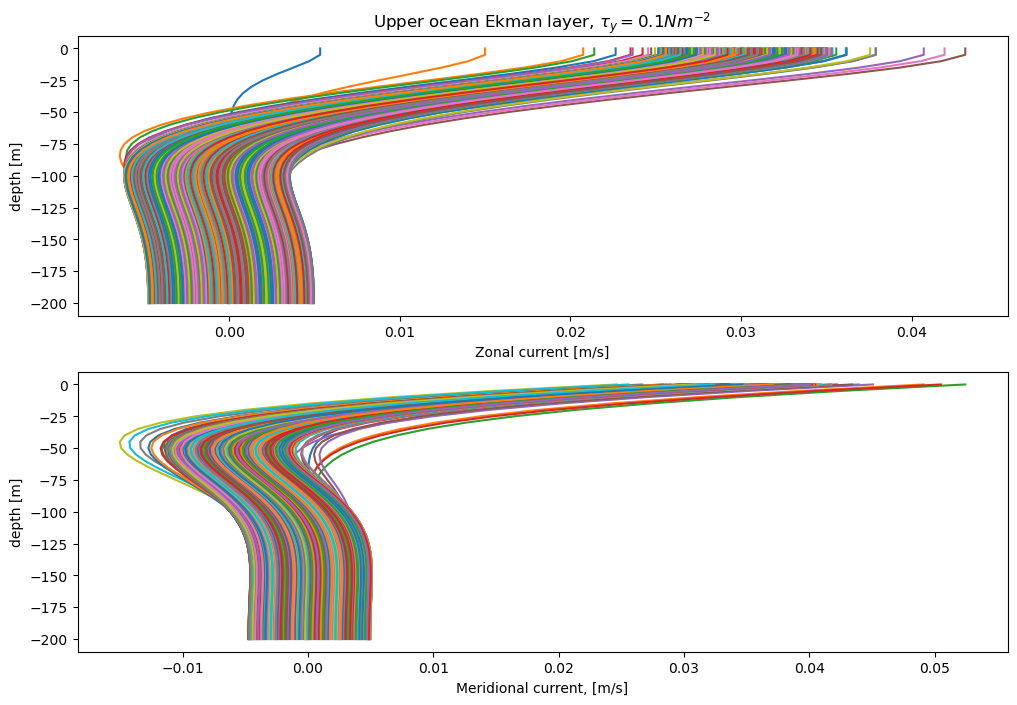

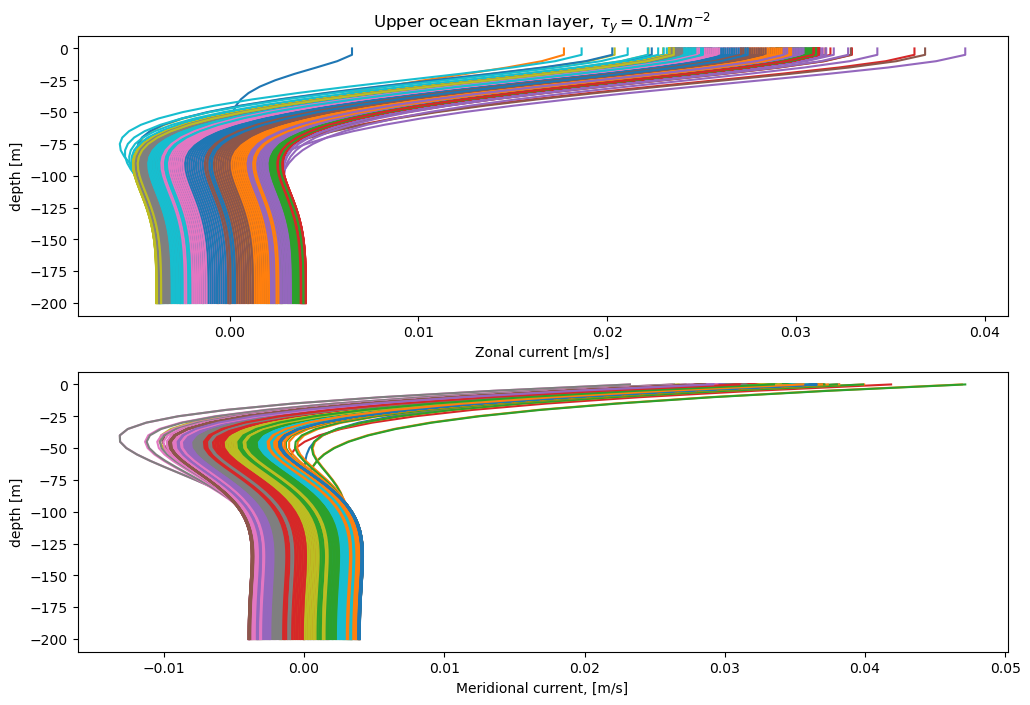

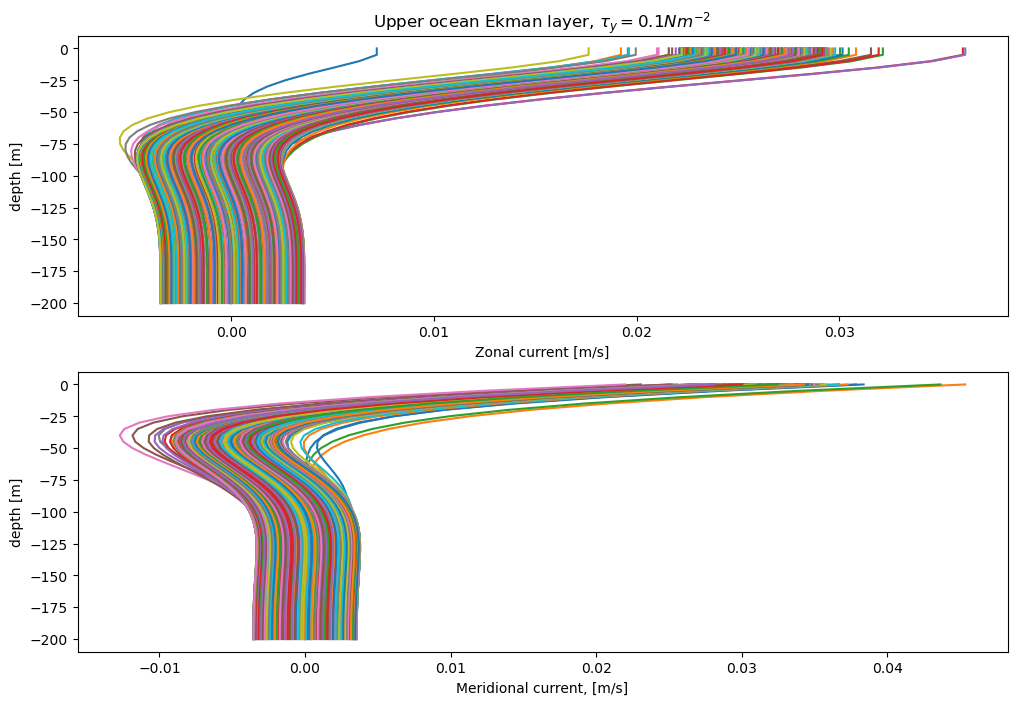

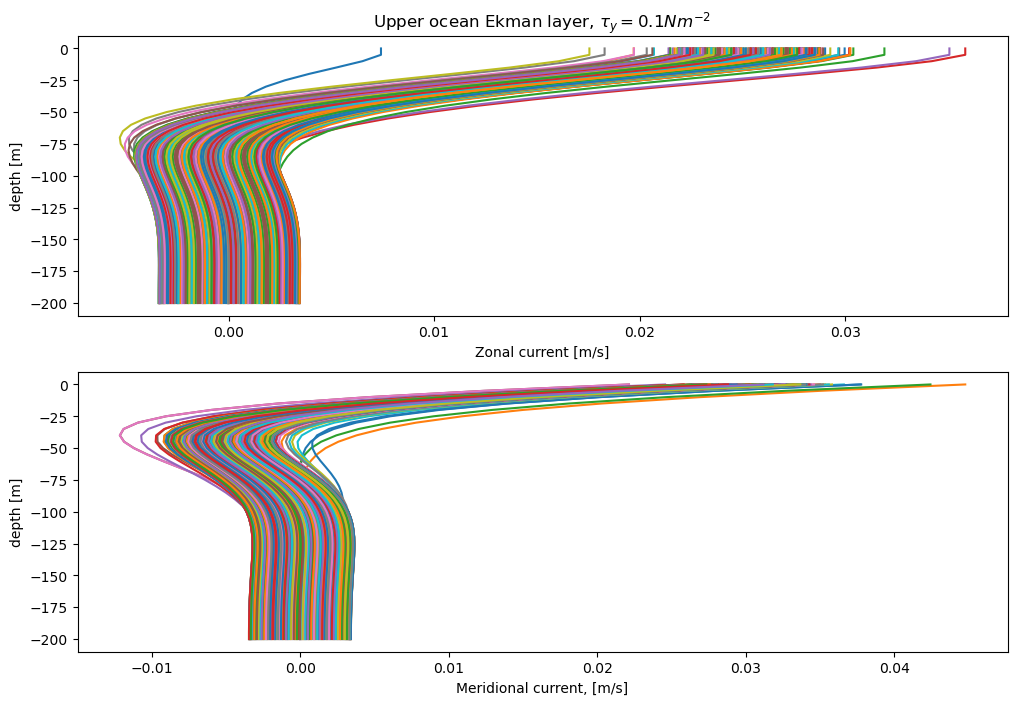

In [265]:
Tau = shearstress(Ws,Wd)

lat = 0.1
uLat00,vLat00 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.1, rho0, A, lat)

lat = 15
uLat15,vLat15 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.1, rho0, A, lat)

lat = 30
uLat30,vLat30 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.1, rho0, A, lat)

lat = 45
uLat45,vLat45 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.1, rho0, A, lat)

lat = 60
uLat60,vLat60 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.1, rho0, A, lat)

lat = 75
uLat75,vLat75 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.1, rho0, A, lat)

lat = 90

uLat90,vLat90 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.1, rho0, A, lat)

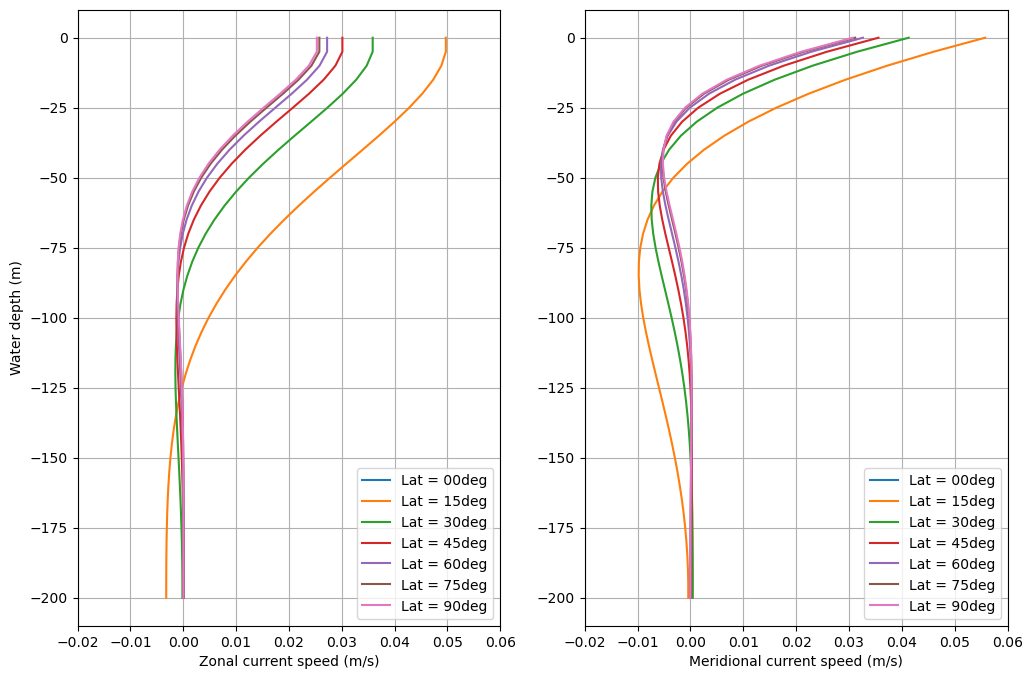

In [241]:
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(np.mean(uLat00,axis=1),z, label = "Lat = 00deg")
ax1.plot(np.mean(uLat15,axis=1),z, label = "Lat = 15deg")
ax1.plot(np.mean(uLat30,axis=1),z, label = "Lat = 30deg")
ax1.plot(np.mean(uLat45,axis=1),z, label = "Lat = 45deg")
ax1.plot(np.mean(uLat60,axis=1),z, label = "Lat = 60deg")
ax1.plot(np.mean(uLat75,axis=1),z, label = "Lat = 75deg")
ax1.plot(np.mean(uLat90,axis=1),z, label = "Lat = 90deg")

ax2.plot(np.mean(vLat00,axis=1),z, label = "Lat = 00deg")
ax2.plot(np.mean(vLat15,axis=1),z, label = "Lat = 15deg")
ax2.plot(np.mean(vLat30,axis=1),z, label = "Lat = 30deg")
ax2.plot(np.mean(vLat45,axis=1),z, label = "Lat = 45deg")
ax2.plot(np.mean(vLat60,axis=1),z, label = "Lat = 60deg")
ax2.plot(np.mean(vLat75,axis=1),z, label = "Lat = 75deg")
ax2.plot(np.mean(vLat90,axis=1),z, label = "Lat = 90deg")

ax1.set_ylabel("Water depth (m)")
ax1.grid(True)
ax2.grid(True)

ax1.set_xlabel("Zonal current speed (m/s)")
ax2.set_xlabel("Meridional current speed (m/s)")

ax1.set_xlim(-0.02,0.06)
ax2.set_xlim(-0.02,0.06)

ax1.legend()
ax2.legend()

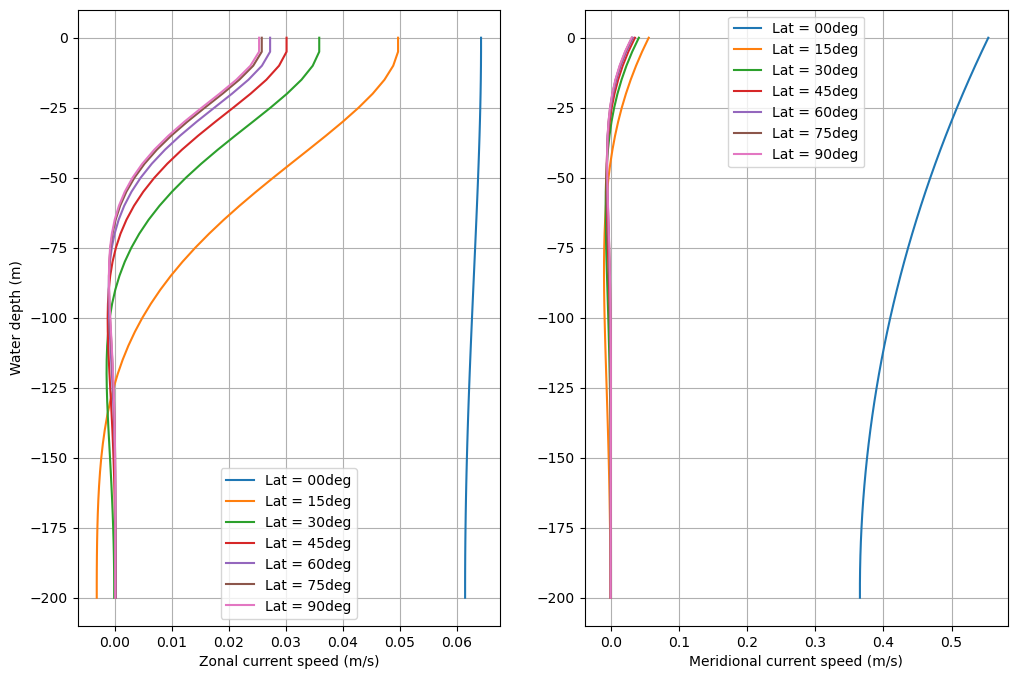

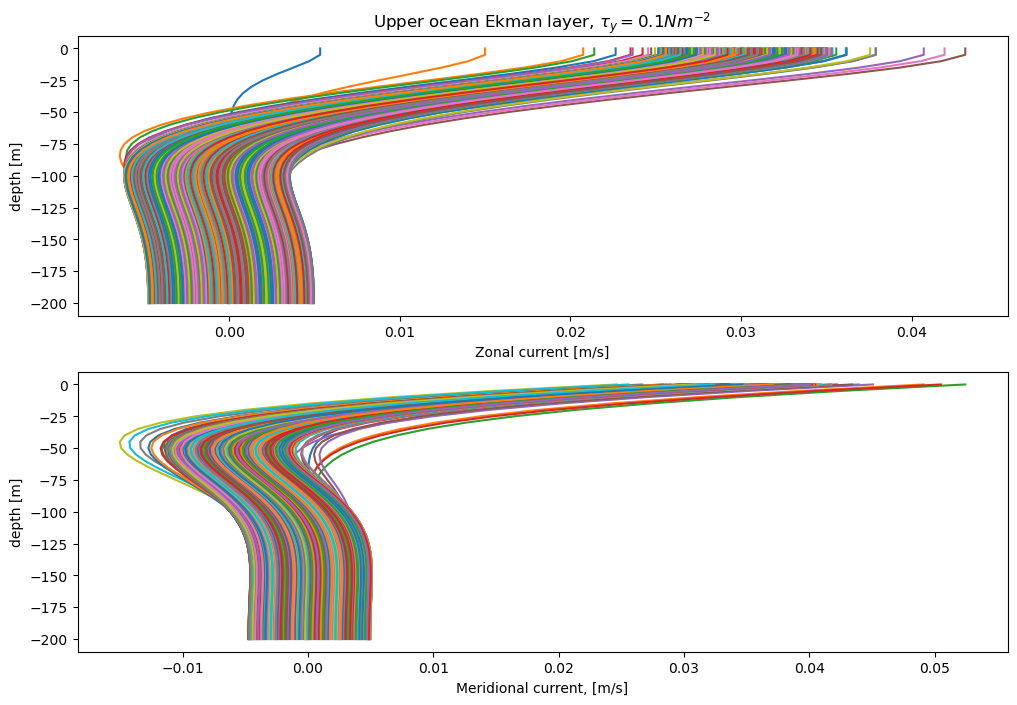

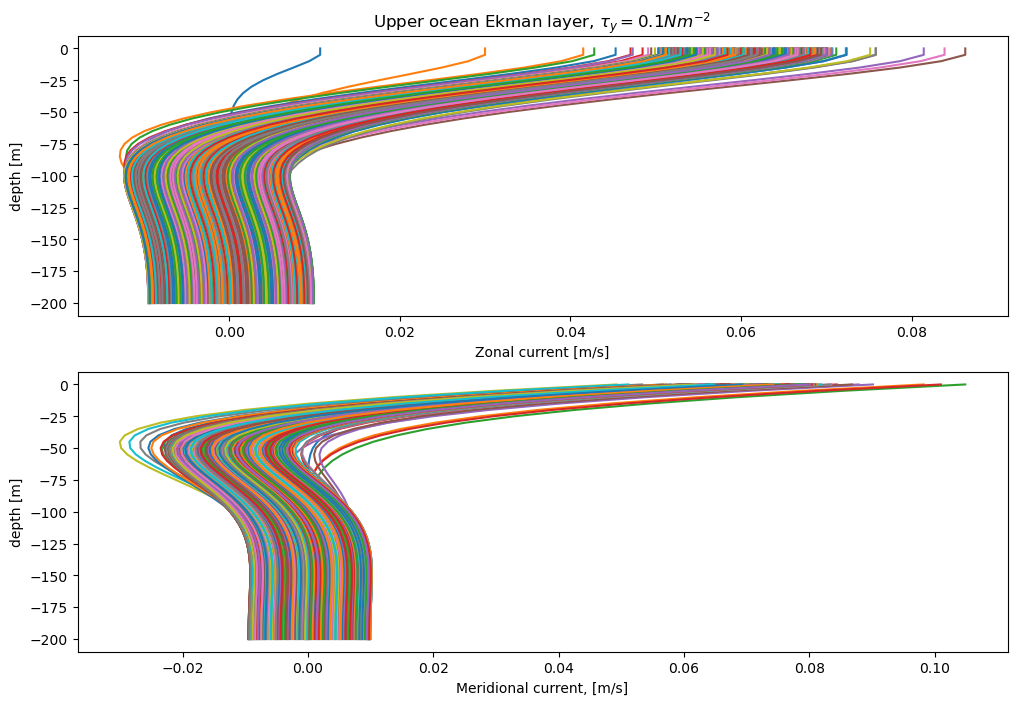

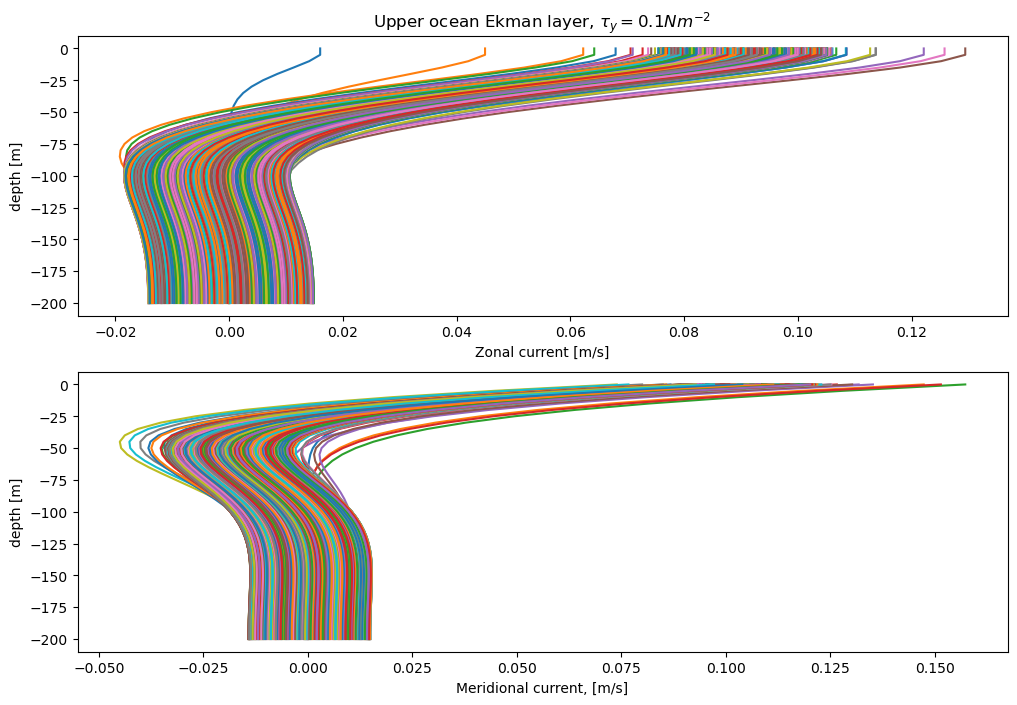

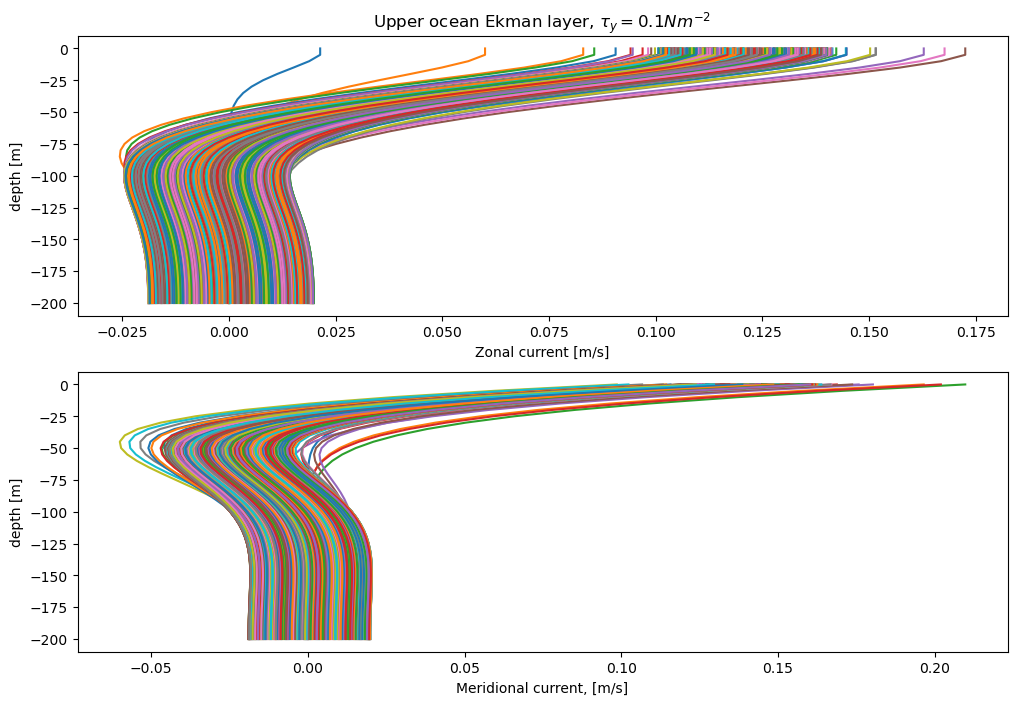

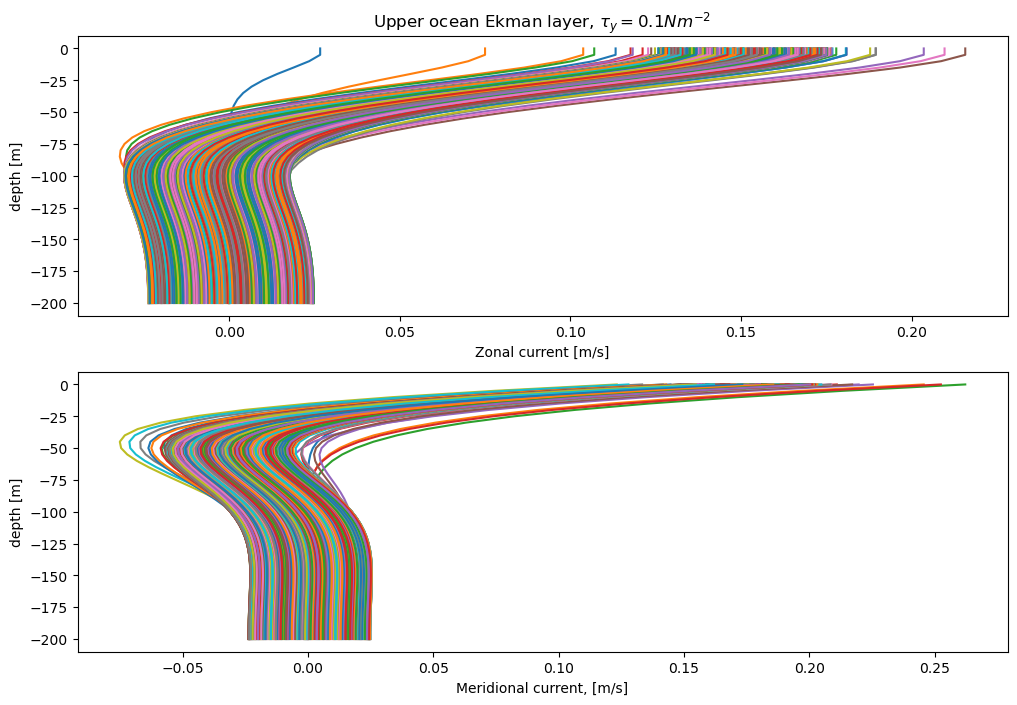

In [266]:
Tau = shearstress(Ws,Wd)

lat = 45

u01,v01 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.1, rho0, A, lat)
u02,v02 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.2, rho0, A, lat)
u03,v03 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.3, rho0, A, lat)
u04,v04 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.4, rho0, A, lat)
u05,v05 = simulate_ekman_transport(nstep, time, dt, z, w, 0, 0.5, rho0, A, lat)



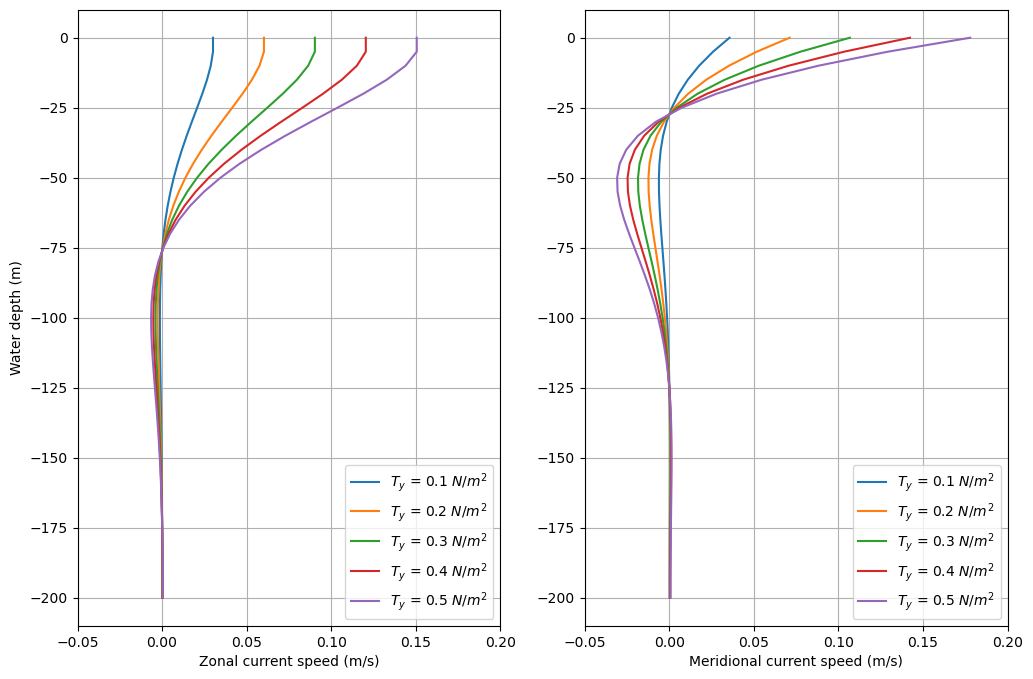

In [253]:
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(np.mean(u01,axis=1),z, label = r"$T_y$ = 0.1 $N/m^2$")
ax1.plot(np.mean(u02,axis=1),z, label = r"$T_y$ = 0.2 $N/m^2$")
ax1.plot(np.mean(u03,axis=1),z, label = r"$T_y$ = 0.3 $N/m^2$")
ax1.plot(np.mean(u04,axis=1),z, label = r"$T_y$ = 0.4 $N/m^2$")
ax1.plot(np.mean(u05,axis=1),z, label = r"$T_y$ = 0.5 $N/m^2$")

ax2.plot(np.mean(v01,axis=1),z, label = r"$T_y$ = 0.1 $N/m^2$")
ax2.plot(np.mean(v02,axis=1),z, label = r"$T_y$ = 0.2 $N/m^2$")
ax2.plot(np.mean(v03,axis=1),z, label = r"$T_y$ = 0.3 $N/m^2$")
ax2.plot(np.mean(v04,axis=1),z, label = r"$T_y$ = 0.4 $N/m^2$")
ax2.plot(np.mean(v05,axis=1),z, label = r"$T_y$ = 0.5 $N/m^2$")

ax1.set_ylabel("Water depth (m)")
ax1.grid(True)
ax2.grid(True)

ax1.set_xlabel("Zonal current speed (m/s)")
ax2.set_xlabel("Meridional current speed (m/s)")

ax1.set_xlim(-0.05,0.20)
ax2.set_xlim(-0.05,0.20)

ax1.legend()
ax2.legend()

In [ ]:

import matplotlib as mpl

mpl.rcParams['animation.embed_limit'] = 50

f1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
u1, = ax1.plot(u01[:,0],z, label = r"$T_y$ = 0.1 $N/m^2$")
u2, = ax1.plot(u02[:,0],z, label = r"$T_y$ = 0.2 $N/m^2$")
u3, = ax1.plot(u03[:,0],z, label = r"$T_y$ = 0.3 $N/m^2$")

title1 = ax1.set_title("")

v1, = ax2.plot(v01[:,0],z, label = r"$T_y$ = 0.1 $N/m^2$")
v2, = ax2.plot(v02[:,0],z, label = r"$T_y$ = 0.2 $N/m^2$")
v3, = ax2.plot(v03[:,0],z, label = r"$T_y$ = 0.3 $N/m^2$")

w1, = ax3.plot((v01[:,0]**2 + u01[:,0]**2)**0.5,z, label = r"$T_y$ = 0.1 $N/m^2$")
w2, = ax3.plot((v02[:,0]**2 + u02[:,0]**2)**0.5,z, label = r"$T_y$ = 0.2 $N/m^2$")
w3, = ax3.plot((v03[:,0]**2 + u03[:,0]**2)**0.5,z, label = r"$T_y$ = 0.3 $N/m^2$")

ax1.set_xlabel('Zonal Current Speed (m/s)')
ax2.set_xlabel('Meridional Current Speed (m/s)')
ax3.set_xlabel("Current Magnitude (m/s)")

ax1.set_ylabel("Water depth (m)")

ax1.set_xlim(-0.12,0.12)
ax1.set_ylim(-200,0)
ax1.legend()

ax2.set_xlim(-0.12,0.12)
ax2.set_ylim(-200,0)
ax2.legend()

ax3.set_xlim(0,0.2)
ax3.set_ylim(-200,0)
ax3.legend()

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

dt = 200

def animate(i):
    
    title1.set_text(f"Zonal Current - Timestep {round((i*25*dt)/86400,1)} days")

    u1.set_xdata(u01[:,i])
    u2.set_xdata(u02[:,i])
    u3.set_xdata(u03[:,i])

    v1.set_xdata(v01[:,i])
    v2.set_xdata(v02[:,i])
    v3.set_xdata(v03[:,i])

    w1.set_xdata((u01[:,i]**2 + v01[:,i]**2)**0.5)
    w2.set_xdata((u02[:,i]**2 + v02[:,i]**2)**0.5)
    w3.set_xdata((u03[:,i]**2 + v03[:,i]**2)**0.5)
    return u1,u2,u3,v1,v2,v3,w1,w2,w3

    # create the animation and loop (interval is in ms)
ani = animation.FuncAnimation(
f1, animate, interval=dt, blit=True, frames=int(nstep/25), repeat=True)

from IPython.display import HTML
HTML(ani.to_jshtml())



In [273]:
u01.shape



(41, 345)

In [274]:
345*25*200/86400


19.96527777777778